# Unshuffled eigen values and vectors

This notebook compares some algorithms to obtain an unshuffled set of eigen values and vectors to allow a parametric analysis of them. It uses the telegrapher's equation for a multiconductor transmission line as an example.

In [1]:
import warnings
import numpy as np
from numpy import cos, sin
from numpy.linalg import norm, lstsq, eig
from scipy.constants import mu_0, epsilon_0, pi
from scipy.optimize import least_squares, linear_sum_assignment
from scipy.linalg import orth, qr
from eigenshuffle import eigenshuffle_eig
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
save_results = True

## Problem Context

The telegrapher's equation in frequency domain (Laplace Transform) for a multiconductor transmission line relates the voltage $\mathbf{V}(x)$ and current $\mathbf{I}(x)$ vectors on each conductor along their length $x$ with their per unit length series impedance $\mathbf{Z}$ and shunt admittance $\mathbf{Y}$ matrices. Both these matrices are complex and symmetric, but not Hermitian. The matrix product $\mathbf{Y} \mathbf{Z}$ is called current propagation matrix, and the matrix product $\mathbf{Z} \mathbf{Y}$ is called the voltage propagation matrix.

$$
\frac{\mathrm{d}^2 \mathbf{V}(x)}{\mathrm{d} x^2} = \mathbf{Z} \mathbf{Y} \cdot \mathbf{V}(x)
$$

$$
\frac{\mathrm{d}^2 \mathbf{I}(x)}{\mathrm{d} x^2} = \mathbf{Y} \mathbf{Z} \cdot \mathbf{I}(x)
$$

The $n$ coupled equations can be transformed to $n$ independent equations by diagonilizing $\mathbf{Y} \mathbf{Z}$ or $\mathbf{Z} \mathbf{Y}$ using their eigen values and vectors. This is called Modal Decomposition in electrical engineering literature. The diagonalization can be done by solving the eigenproblem

$$
\mathbf{Y} \mathbf{Z} \cdot \mathbf{T_I} = \mathbf{T_I} \cdot \mathbf{\lambda}
$$

where $\mathbf{T_I}$ is the right eigenvector matrix of $\mathbf{Y} \mathbf{Z}$ and $\mathbf{\lambda}$ is a diagonal matrix containing the eigenvalues of $\mathbf{Y} \mathbf{Z}$. Because $\mathbf{Z}$ and $\mathbf{Y}$ are symmetric, and $(ZY)^T = Y^T Z^T$, then the voltage transformation matrix $\mathbf{T_V}$ associated with $\mathbf{ZY}$ is given by $\mathbf{T_V} = \mathbf{T_I}^{-T}$.

We can express the above $n^2$ set of equations into $n$ set of equations for each $\lambda_k$:

$$
(\mathbf{Y} \mathbf{Z} - \lambda_k \mathbf{1}) \cdot \mathbf{T_I}_{(k)} = 0
$$

where $\mathbf{1}$ is the identity matrix and $\mathbf{T_I}_{(k)}$ is the column $k$
 of $\mathbf{T_I}$. A nontrivial solution is found when the determinant of $(\mathbf{Y} \mathbf{Z} - \lambda_k \mathbf{1})$ is zero. That determinant is a order $n$ polynomial for which the $n$ roots are the $\lambda$ values.

Load the pre-computed matrix product $\mathbf{Y} \mathbf{Z}$, also called current propagation matrix. It was calculated for 1000 frequency point, $\log_{10}$ spaced from $1$ Hz to $10^8$ Hz. It corresponds to a 3 phase cable and their conductive sheath inside a steel pipe (7 conductors total). We want to study the modal propagation velocitys and attenuation constants of that system. This is useful for estimating the smallest time a signal needs to travel along that cable and the strength with which it will arrive.

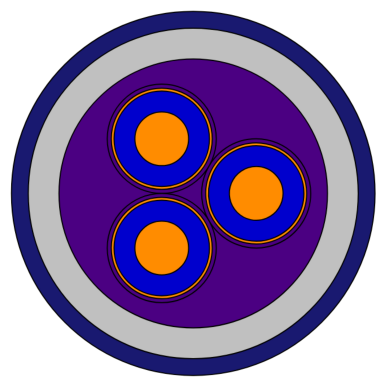

In [3]:
img = mpimg.imread('../data/cable.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
names = ["core 1", "sheath 1", "core 2", "sheath 2", "core 3", "sheath 3", "armor"]
A = np.load("../data/YZ.npy")
fhz = np.load("../data/frequency_Hz.npy")
K, N, _ = A.shape

subset = range(0, K, 10)
A = A[subset]
fhz = fhz[subset]
K, N, _ = A.shape
print(f"K = {K}")

K = 100


In [5]:
def comp_plot_propagation(eigvals, eigvecs):
    """Compute the propagation modes and plot the propagation constant and transformation matrix."""
    gamma = np.sqrt(eigvals)  # propagation constant
    attenuation = np.real(gamma) * 1e3
    velocity = (1e-6 * np.imag(2j * np.pi * fhz) / np.imag(gamma).T).T
    
    # Plot attenuation and velocity
    fig1, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].loglog(fhz, attenuation)
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Attenuation (Np/km)")
    axes[0].grid(which="major", linestyle="-")
    axes[0].grid(which="minor", linestyle="--", linewidth=0.5)
    axes[0].legend([f"Mode {i+1}" for i in range(N)])
    
    axes[1].semilogx(fhz, velocity)
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Propagation velocity (m/μs)")
    axes[1].grid(which="major", linestyle="-")
    axes[1].grid(which="minor", linestyle="--", linewidth=0.5)
    axes[1].legend([f"Mode {i+1}" for i in range(N)])
    
    # Plot propagation modes
    fig2, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=False, sharey=True)
    axes = axes.ravel()
    line_styles = ['-', '--']
    for k in range(N):
        ax = axes[k]
        for comp in range(N):
            style = line_styles[comp % len(line_styles)]
            ax.semilogx(fhz, eigvecs[:, comp, k].real, label=names[comp], linestyle=style)
        ax.set_title(f"Mode {k}")
        ax.grid()
    
    for ax in axes[N:]:
        ax.axis("off")
    
    handles, leg_labels = axes[0].get_legend_handles_labels()
    leg_labels = names
    fig2.legend(handles, leg_labels, loc='center left', bbox_to_anchor=(0.85, 0.5), title="Conductors")
    
    fig2.text(0.5, 0.04, "Frequency (Hz)", ha="left")
    fig2.text(0.04, 0.5, "Current Transformation Matrix", va="center", rotation="vertical")
    fig2.tight_layout(rect=[0.05, 0.05, 0.85, 1])

    return fig1, fig2

## Standard Eigen

First, we try a naive approach of calculation the eigenvalues and vectors, using the standard `eig`.

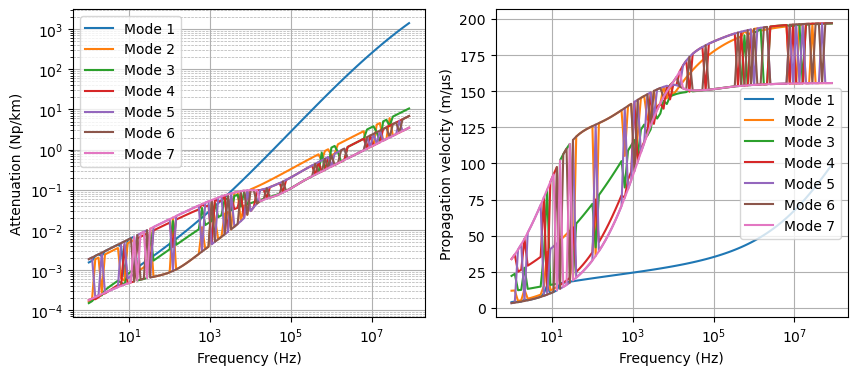

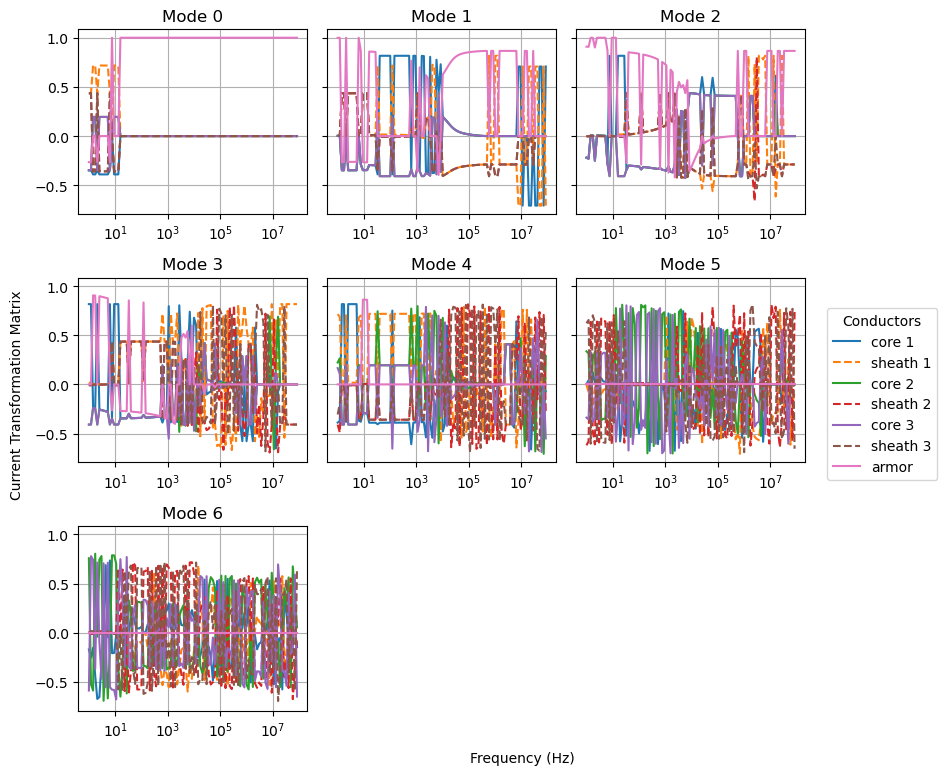

In [6]:
eigvals, eigvecs = np.linalg.eig(A)
fig1, fig2 = comp_plot_propagation(eigvals, eigvecs)
if save_results:
    fig1.savefig("../results/eigenshuffle_vals.png")
    fig2.savefig("../results/eigenshuffle_vecs.png")

We see clear tendencies for the attenuation and the velocity, but they are all shuffled. The eigenvectors are even messier.

## Munkres Assignment

An alternative is to use the eigenshuffle package, which solves the [Assignment problem](https://en.wikipedia.org/wiki/Assignment_problem) with the [Hungarian (Munkres) algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm). Originally it is a [MATLAB package](https://www.mathworks.com/matlabcentral/fileexchange/22885-eigenshuffle). There is [python version of it](https://github.com/ograsdijk/eigenshuffle), installable through pip. Version 0.1.0 is compatible with numpy 1.26. Version 0.1.2 is made for numpy 2.0.

Eigenshuffle is very fast, but not as consistent for my use cases. Increasing the number of points per frequency decade does not help. Maybe tweaking the cost function of the munkres can give a better result?

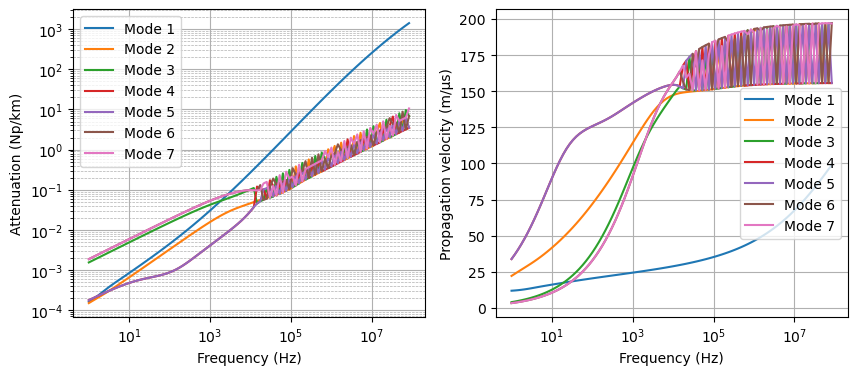

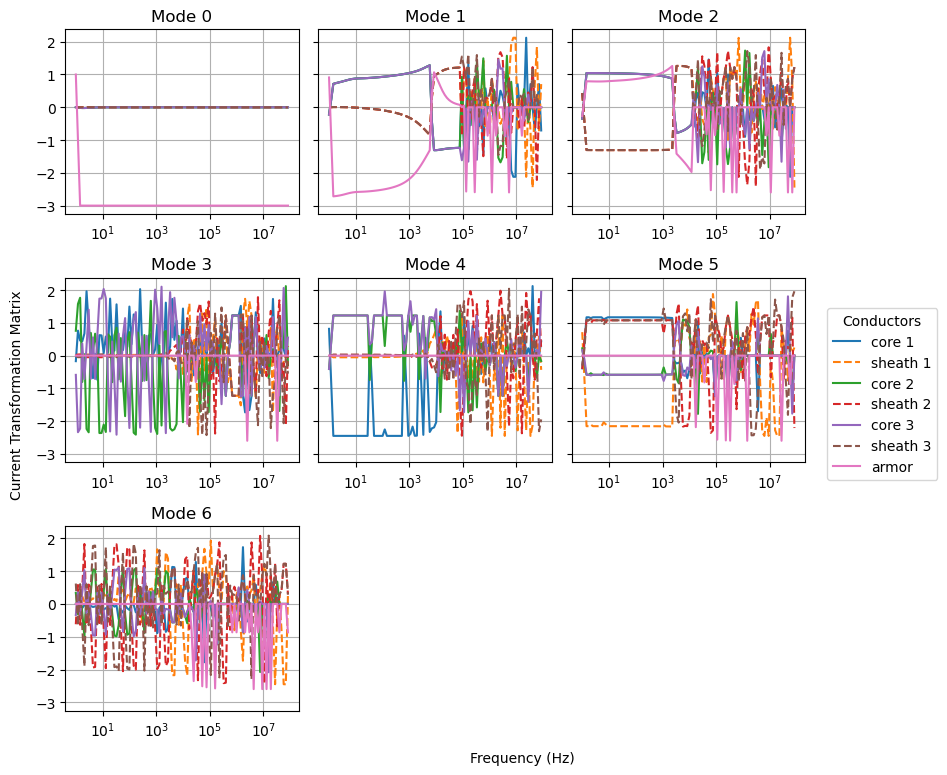

In [7]:
eigvals, eigvecs = eigenshuffle_eig(A, False)  # True gives a worse result
fig1, fig2 = comp_plot_propagation(eigvals, eigvecs)
if save_results:
    fig1.savefig("../results/eigenshuffle_vals.png")
    fig2.savefig("../results/eigenshuffle_vecs.png")

Better than standard eigen, but still shuffled.

## Optimization and postprocessing (OPP Method)

Based on the paper:

> S. Fan, Y. Li, X. Li and L. Bi, "A Method for the Calculation of Frequency-Dependent Transmission Line Transformation Matrices," in IEEE Transactions on Power Systems, vol. 24, no. 2, pp. 552-560, May 2009, [doi: 10.1109/TPWRS.2009.2016381.](https://doi.org/10.1109/TPWRS.2009.2016381)

Let $\{\mathbf{x}_j\}_{j=1}^n$ denote the eigenvectors computed at frequency $\omega_k$ using the OPP method. At the subsequent frequency $\omega_{k+1}$, we first compute raw eigenvectors $\{\mathbf{v}_j\}_{j=1}^n$ using conventional methods, then refine them via OPP to obtain the final eigenvectors $\{\mathbf{w}_j\}_{j=1}^n$. Let $\mathbf{V}_j = \text{Span}\{v_j\}$ and $\mathbf{V} = \cup_{j=1}^n \mathbf{V}_j$, where $\mathbf{V}_j$ denotes the set that consists of all the eigenvectors obtained by multiplying $\mathbf{v}_j$ with an arbitrary complex number, then all the valid eigenvectors at the next frequency point must be in the set $\mathbf{V}$. The idea of the OPP method is to obtain the best $\mathbf{w}_i$ in $\mathbf{V}$ through the following unconstrained optimization problem.

$$
\min_{\mathbf{v} \in \mathbf{V}}\{ \| \mathbf{x}_i - \mathbf{v} \| \} = \| \mathbf{x}_i  - \mathbf{w}_i \|
$$

Assume $\min_{\mathbf{v} \in \mathbf{V}_j} \{ \| \mathbf{x}_i - \mathbf{v} \| \} = \| \mathbf{x}_i  - \mathbf{v}_j^* \|$, where $\mathbf{v}_j^*$ is the vector closest to $\mathbf{x}_i$ in $\mathbf{V}_j$, then

$$
\mathbf{v}_j^* = \frac{\langle \mathbf{x}_i, \mathbf{v}_j \rangle}{\| \mathbf{v}_j \|^2} \mathbf{v}_j
$$

$$
\| \mathbf{x}_i - \mathbf{v}_j^* \| = \sqrt{\| \mathbf{x}_i \|^2 - \frac{|\langle \mathbf{x}_i, \mathbf{v}_j \rangle|^2}{\| \mathbf{v}_j \|^2}}
$$

The minimum distance between $\mathbf{x}_i$ and the eigenvector $\mathbf{V}$ is

$$
\min_{\mathbf{v} \in \mathbf{V}}\{ \| \mathbf{x}_i - \mathbf{v} \| \} =
\min_j \left \{ \min_{\mathbf{v} \in \mathbf{V}_j}\{ \| \mathbf{x}_i - \mathbf{v} \| \} \right  \} = 
\min_j\{ \| \mathbf{x}_i - \mathbf{v}_j^* \| \}
$$

and $\mathbf{w}_i$ can be obtained at the same time. This method is not iterative.

Next we do an extension to the method because the eigenvectors are very sensitive to perturbation. Let $\{\mathbf{\lambda}\}_{j=1}^n$ be the eigenvalues at the next frequency point obtained by conventional methods, $\{\mathbf{\lambda}\}_{j=1}^m$ are the only coalescing eigenvalues apart from the remainder $\{\mathbf{\lambda}\}_{j=m+1}^n$. Although the subspaces $\{\mathbf{V}_j\}_{j=1}^m$ are ver yssensitive to changes in the matrix elements, the subspace $\text{Span}\{\mathbf{\lambda}\}_{j=1}^m$ may be very stable.

Let $\{\mathbf{\tilde\lambda}\}_{j=1}^n$ be the perturbed eigenvalues and $\{\mathbf{\tilde\lambda}\}_{j=m+1}^n$ are still the only coalescing eigenvalues. Let $\{\mathbf{v}_j \, | \, j = 1, \dots, m \}$ be the eigenvectors corresponding to those coalescing eigenvalues after perturbation. All the angles $\alpha_j$ between $\text{Span}\{{v}_j\}$ and $\text{Span}\{\mathbf{\tilde v}_j\}$ are large, however the change of the plane $\text{Span}\{\mathbf{v}_{j_1}, \mathbf{v}_{j_2}\}$ may be minor, denoted by $\theta$.

Let $\mathbf{P} = \text{Span}\{\mathbf{v}_j \, | \, j = 1, \dots, m \}$ and $\mathbf{\Gamma} = \mathbf{P} \cup \left( \cup_{j = m+1}^{n} \mathbf{V}_j \right)$. First, we find the orthogonal base $\{\mathbf{p}_j\}_{j=1}^m$ of $\mathbf{P}$ with, for example, the Gram-Schmidt proces. Then the vector in $\mathbf{P}$ with the minimum distance to $\mathbf{x}_i$ is

$$
\mathbf{p}^* = \sum_{j=1}^m \frac{\langle \mathbf{x}_i, \mathbf{p}_j \rangle}{\| \mathbf{p}_j \|^2} \mathbf{p}_j
$$

and the minimum distance is 

$$
\| \mathbf{x}_i - \mathbf{p}^* \| = \sqrt{\| \mathbf{x}_i \|^2 - \sum_{j=1}^m \frac{|\langle \mathbf{x}_i, \mathbf{p}_j \rangle|^2}{\| \mathbf{p}_j \|^2}}
$$

The difficulty is to identify the coalescing eigenvalues. A criterion like

$$
\frac{|\lambda_i - \lambda_j|}{\| \mathbf{YZ} \|} < \epsilon
$$

is recommended.

In [8]:
def opp_tracking(S_sequence, eps=1e-12, history_weight=0.3):
    """Track eigenvectors across frequencies using OPP method.
    
    Parameters
    ----------
    S_omega: array of complex symmetric matrices at each frequency (K x N x N)
    eps: float tolerance for finding coalescing groups
        
    Returns
    -------
    eigenvalues: array of eigenvalues (K x N)
    eigenvectors: array of eigenvectors (K x N x N)

    References
    ----------
    S. Fan, Y. Li, X. Li and L. Bi, "A Method for the Calculation of Frequency-Dependent
    Transmission Line Transformation Matrices," in IEEE Transactions on Power Systems,
    vol. 24, no. 2, pp. 552-560, May 2009, doi: 10.1109/TPWRS.2009.2016381.
    """
    K, N, _ = S_sequence.shape
    eigvals = np.zeros((K, N), dtype=complex)
    eigvecs = np.zeros((K, N, N), dtype=complex)
    
    # Initialize with exact solution at first frequency
    eigvals[0], eigvecs[0] = np.linalg.eig(S_sequence[0])
    
    for k in range(1, K):
        current_eigvals, current_eigvecs = np.linalg.eig(S_sequence[k])
        
        # Build cost matrix incorporating historical trends
        cost = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                # Current projection distance
                proj_dist = 1 - abs(np.vdot(eigvecs[k-1, :, i], current_eigvecs[:, j]))
                
                # Historical trend penalty (if available)
                hist_penalty = 0
                if k > 1:
                    prev_diff = abs(eigvals[k-1, i] - eigvals[k-2, i])
                    curr_diff = abs(current_eigvals[j] - eigvals[k-1, i])
                    hist_penalty = abs(prev_diff - curr_diff)
                
                cost[i, j] = proj_dist + history_weight * hist_penalty
        
        # Solve assignment problem
        row_ind, col_ind = linear_sum_assignment(cost)
        
        # Apply with coalescence handling
        eigvals[k] = current_eigvals[col_ind]
        eigvecs[k] = current_eigvecs[:, col_ind]
        
        # Phase alignment
        for i in range(N):
            if np.vdot(eigvecs[k-1, :, i], eigvecs[k, :, i]).real < 0:
                eigvecs[k, :, i] *= -1
    
    return eigvals, eigvecs

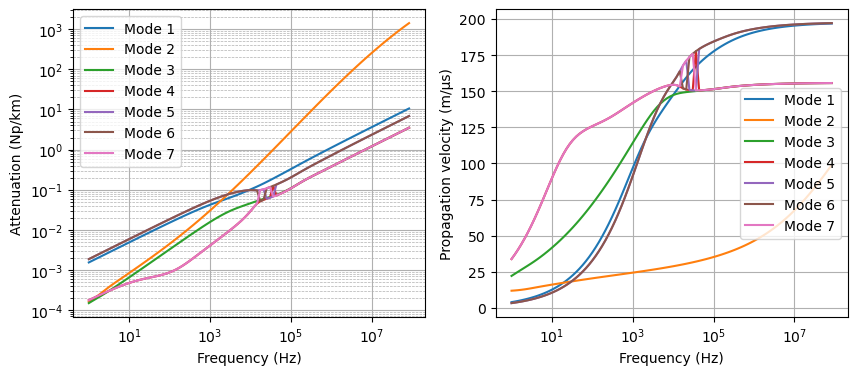

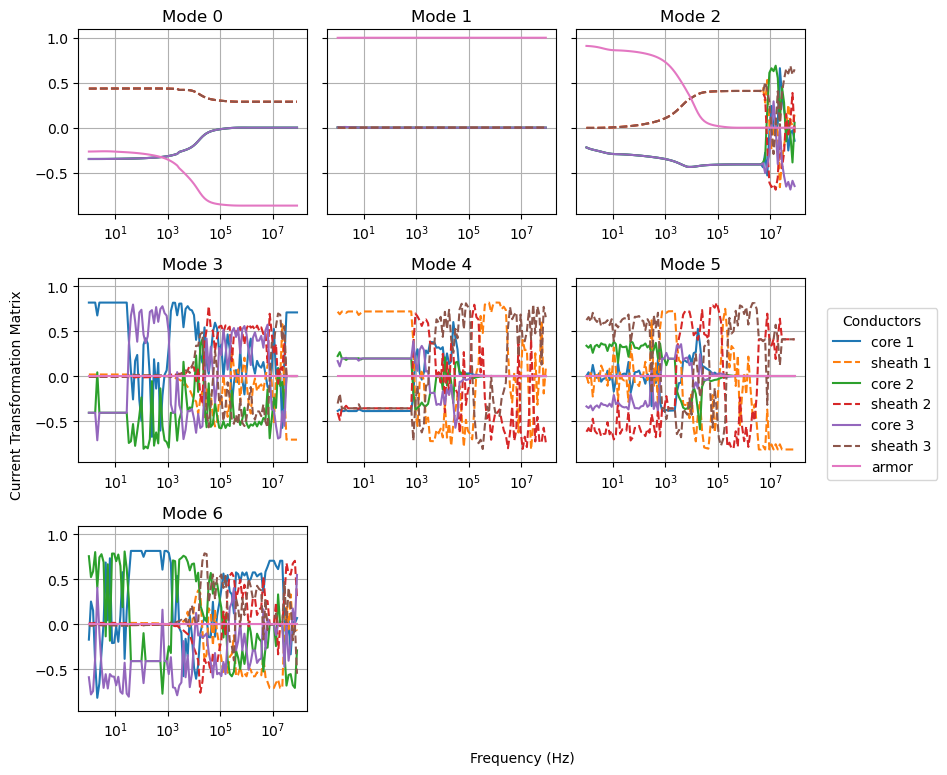

In [9]:
eigvals, eigvecs = opp_tracking(A)
fig1, fig2 = comp_plot_propagation(eigvals, eigvecs)
if save_results:
    fig1.savefig("../results/OPP_vals.png")
    fig2.savefig("../results/OPP_vecs.png")

Maybe we can combine the Munkres (eigenshuffle) and OPP methods for something fast and more robust?

## Newton-Raphson Method

Based on the paper:

> L. M. Wedepohl, H. V. Nguyen and G. D. Irwin, "Frequency-dependent transformation matrices for untransposed transmission lines using Newton-Raphson method," in IEEE Transactions on Power Systems, vol. 11, no. 3, pp. 1538-1546, Aug. 1996, [doi: 10.1109/59.535695.](https://doi.org/10.1109/59.535695)

An option to solve the eigenproblem is to treat it as an optimization problem.

$$
(\mathbf{Y} \mathbf{Z} - \lambda_k \mathbf{1}) \cdot \mathbf{T_I}_{(k)} = 0
$$

$$
\|\mathbf{T_I}_{(k)}\|_2 = 1
$$

We add an additional equation to the eigenproblem so that the 2-norm of the eigenvector $k$ is 1. This constraints helps to keep consistency in the eigenvectors and to avoid numerical overflows due to divisions by zero. Then, at each frequency, we use the solution of the previous frequency as the starting value of the solution. The very first value is obtained by a stardard eigen solver.

In [10]:
def rotate(S):
    """Rotates the eigenvector matrix to minimize its imaginary part.

    Complements the Newton-Raphson method.

    Example:
    ```
    # A is an array of shape (K, N, N)
    eigvals = np.zeros((K, N), dtype=complex)
    eigvecs = np.zeros((K, N, N), dtype=complex)
    eigvals[0], eigvecs[0] = eig(A[0])
    eigvals[0], eigvecs[0] = eig_newton_raphson(A[0], eigvals[0], rotate(eigvecs[0]))
    for k in range(1, K):
        eigvals[k], eigvecs[k] = eig_newton_raphson(A[k], evvals[k - 1], eigvecs[k - 1])
    ```

    Parameters
    ----------
    S: np.ndarray of complex, shape (N, N)
        Eigenvectors matrix

    Retorna
    -------
    rotate(S): np.ndarray of complex, shape (N, N)
        Matrix with imaginary part minimized.
    """
    Nc = S.shape[0]
    scale1 = np.zeros(Nc, dtype=complex)
    scale2 = np.copy(scale1)
    scale = np.copy(scale1)
    ang = np.copy(scale1)
    err1 = np.copy(scale1)
    err2 = np.copy(scale1)
    numerator = np.zeros(Nc, dtype=float)
    denominator = np.copy(numerator)
    SA = np.zeros((Nc, Nc), dtype=complex)
    SB = np.copy(SA)
    for col in range(Nc):
        for j in range(Nc):
            numerator[col] += np.imag(S[j, col]) * np.real(S[j, col])
            denominator[col] += (
                np.real(S[j, col]) ** 2 - np.imag(S[j, col]) ** 2
            )

        numerator[col] *= -2
        ang[col] = 0.5 * np.arctan2(denominator[col], numerator[col])
        scale1[col] = cos(ang[col]) + 1j * sin(ang[col])
        scale2[col] = cos(ang[col] + pi / 2) + 1j * sin(ang[col] + pi / 2)
        aaa = bbb = ccc = ddd = eee = fff = 0.0

        for j in range(Nc):
            SA[j, col] *= scale1[col]
            SB[j, col] *= scale2[col]
            aaa += np.imag(SA[j, col]) ** 2
            bbb += np.real(SA[j, col]) * np.imag(SA[j, col])
            ccc += np.real(SA[j, col]) ** 2
            ddd += np.imag(SB[j, col]) ** 2
            eee += np.real(SB[j, col]) * np.imag(SB[j, col])
            fff += np.real(SB[j, col]) ** 2

        err1[col] = (
            aaa * cos(ang[col]) ** 2
            + bbb * sin(2 * ang[col])
            + ccc * sin(ang[col]) ** 2
        )
        err2[col] = (
            ddd * cos(ang[col]) ** 2
            + eee * sin(2 * ang[col])
            + fff * sin(ang[col]) ** 2
        )
        if np.abs(err1[col]) < np.abs(err2[col]):
            scale[col] = scale1[col]
        else:
            scale[col] = scale2[col]

        S[:, col] *= scale[col]

    return S

In [11]:
def eig_newton_raphson(
    Ak,
    prev_eigvalues,
    prev_eigvectors,
    tol=1e-9,
    maxiter=10000,
):
    """Calculates the eigenvalues and eigenvectors of `Ak` by Newton-Raphson method.

    Example:
    ```
    # A is an array of shape (K, N, N)
    eigvals = np.zeros((K, N), dtype=complex)
    eigvecs = np.zeros((K, N, N), dtype=complex)
    eigvals[0], eigvecs[0] = eig(A[0])
    for k in range(1, K):
        eigvals[k], eigvecs[k] = eig_newton_raphson(A[k], eigvals[k - 1], eigvecs[k - 1])
    ```

    Parameters
    ----------
    Ak: np.ndarray of complex, shape (N, N)
        Matrix `A[k]` for which the eigenvalues and eigenvectors are desired.
    prev_eigvalues: np.ndarray of complex, shape (N,)
        Eigenvalues of `A[k - 1]`.
    prev_eigvectors: np.ndarray of complex, shape (N, N)
        Right normalized eigenvectors of `A[k - 1]`.
    tol: float
        Tolerance to consider convergence.
    maxiter: int
        Maximum number of iterations.

    Returns
    -------
    eigvals: np.ndarray of complex, shape (N,)
        Eigenvalues `A[k]`.
    eigvectors: np.ndarray of complex, shape (N, N)
        Right normalized eigenvectors `A[k]`.

    References
    ----------
    L. M. Wedepohl, H. V. Nguyen and G. D. Irwin, "Frequency-dependent
    transformation matrices for untransposed transmission lines using
    Newton-Raphson method," in IEEE Transactions on Power Systems, vol. 11,
    no. 3, pp. 1538-1546, Aug. 1996, doi: 10.1109/59.535695.
    """
    N = Ak.shape[0]
    scale = norm(Ak)
    A = Ak / scale
    eigvals = np.zeros(N, dtype=complex)
    eigvectors = np.zeros((N, N), dtype=complex)
    jac = np.zeros((N + 1, N + 1), dtype=complex)
    idm = np.identity(N)
    for i in range(N):
        d = prev_eigvalues[i]
        v = prev_eigvectors[:, i]
        for itr in range(maxiter):
            jac[0:N, 0:N] = A - d * idm
            jac[0:N, N] = -v
            jac[N, 0:N] = 2 * v.conj()
            res = np.hstack((A @ v - v * d, v.conj() @ v - 1))
            vec, residues, rank, sv = lstsq(jac, res)
            res1 = np.max(np.abs(vec))
            v = v - vec[0:N]
            d = d - vec[N]
            if res1 < tol:
                break
            elif itr == maxiter - 1:
                msg = f"Convergence not achieved for eigenvalue {i}."
                warnings.warn(msg)

        nv = norm(v)
        if nv == 0:
            warnings.warn(f"Zero vector encountered for eigenvalue {i}, replacing with previous eigenvector.")
            v = prev_eigvectors[:, i]
            nv = norm(v)
        eigvals[i] = d * scale
        eigvectors[:, i] = v / nv

    return eigvals, eigvectors

C:\Users\pedro\AppData\Local\Temp\ipykernel_25020\502027592.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  vec, residues, rank, sv = lstsq(jac, res)
C:\Users\pedro\AppData\Local\Temp\ipykernel_25020\502027592.py:70: UserWarning: Convergence not achieved for eigenvalue 6.
  warnings.warn(msg)
C:\Users\pedro\AppData\Local\Temp\ipykernel_25020\502027592.py:70: UserWarning: Convergence not achieved for eigenvalue 3.
  warnings.warn(msg)
C:\Users\pedro\AppData\Local\Temp\ipykernel_25020\502027592.py:70: UserWarning: Convergence not achieved for eigenvalue 2.
  warnings.warn(msg)


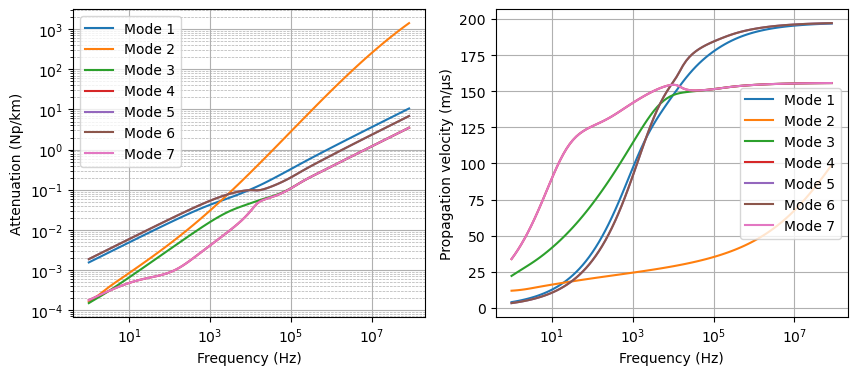

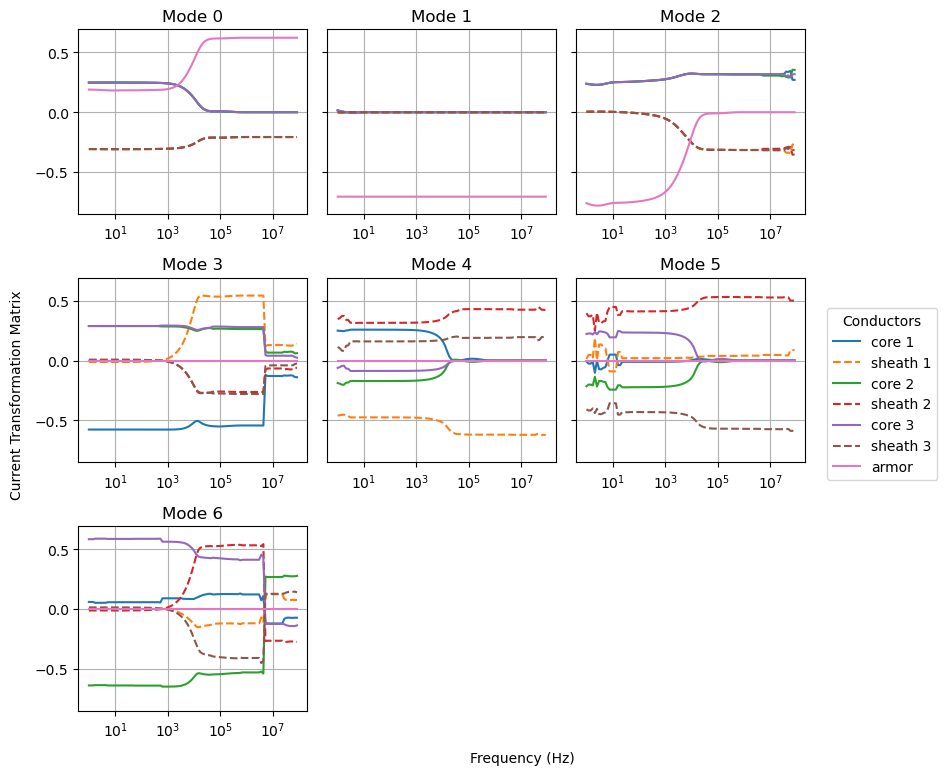

In [12]:
eigvals = np.zeros((K, N), dtype=complex)
eigvecs = np.zeros((K, N, N), dtype=complex)
eigvals[0], eigvecs[0] = eig(A[0])
eigvals[0], eigvecs[0] = eig_newton_raphson(A[0], eigvals[0], rotate(eigvecs[0]))
eigvals[0], eigvecs[0] = eig_newton_raphson(A[0], eigvals[0], rotate(eigvecs[0]))
for k in range(1, K):
    eigvals[k], eigvecs[k] = eig_newton_raphson(A[k], eigvals[k - 1], eigvecs[k - 1], maxiter=20000)

fig1, fig2 = comp_plot_propagation(eigvals, eigvecs)
if save_results:
    fig1.savefig("../results/NR_vals.png")
    fig2.savefig("../results/NR_vecs.png")

Almost, but it seems there is some shuffling still happening and some failed convergences because of repeated eigenvalues.

## Sequential Quadratic Programming

The paper

> T. T. Nguyen and H. Y. Chan, "Evaluation of modal transformation matrices for overhead transmission lines and underground cables by optimization method," in IEEE Transactions on Power Delivery, vol. 17, no. 1, pp. 200-209, Jan. 2002, [doi: 10.1109/61.974208.](https://doi.org/10.1109/61.974208)

uses sequential quadratic programming (SQP) to solve the eigen problem. The formulation is very similar to the one in the Levenberg--Marquardt (LM) method. I did not implement this one. From what I've read, the LM method is much more robust than either the SQP and Newton-Raphson (NR) methods.

## Levenberg--Marquardt Method

Based on the paper:

> A. I. Chrysochos, T. A. Papadopoulos and G. K. Papagiannis, "Robust Calculation of Frequency-Dependent Transmission-Line Transformation Matrices Using the Levenberg–Marquardt Method," in IEEE Transactions on Power Delivery, vol. 29, no. 4, pp. 1621-1629, Aug. 2014, [doi: 10.1109/TPWRD.2013.2284504.](https://doi.org/10.1109/TPWRD.2013.2284504)

We are calculating the eigenvalues and vectors as a function of the angular frequency $\omega$ of a complex and symmetric $N \times N$ matrix $\mathbf{S}(\omega)$ using the Levenberg--Marquardt method. Each eigenvalue/vector pair satisfies $\mathbf{S} \cdot \mathbf{t} - \lambda \cdot \mathbf{t}$.

For better convergence, a normalization of $\mathbf{S}$ is needed. The paper recommends in the context of transmission lines:

$$
\mathbf{S}(\omega) = \frac{\mathbf{YZ}(\omega)}{-\omega^2 \mu_0 \varepsilon_0} - \mathbf{1}
$$

We do a real-valued equivalent formulation.

$$
\mathbf{S}_C = \begin{bmatrix}
\mathbf{S}_\text{re} & -\mathbf{S}_\text{im} \\
\mathbf{S}_\text{im} & \mathbf{S}_\text{re}
\end{bmatrix}
$$

$$
\mathbf{t}_C = \begin{bmatrix} \mathbf{t}_\text{re} & \mathbf{t}_\text{im} \end{bmatrix}
$$

$$
\mathbf{\lambda}_C = \begin{bmatrix} \lambda_\text{re} \mathbf{I} & -\lambda_\text{im} \mathbf{I} \\
\lambda_\text{im} \mathbf{I} & \lambda_\text{re} \mathbf{I} \end{bmatrix}
$$

$$
\mathbf{S}_C \cdot \mathbf{t} - \mathbf{\lambda}_C \cdot \mathbf{t}_C = \mathbf{0}
$$

We add two additional constraints so that the sum of complex elements of $\mathbf{t}$ is unity

$$
\sum_{i=1}^{N} \mathbf{t}_C^2(i) - \sum_{i=N+1}^{2N} \mathbf{t}_C^2(i) = 1
$$

$$
\sum_{i=1}^{N} \mathbf{t}_C^2(i) \cdot \mathbf{t}_C^2(N+i) = 0
$$

The equations above are grouped into the real-valued vector function $\mathbf{f}$ of size $2N+2$ which tends to zero for the solution pair of $\mathbf{t}_C$ and $\mathbf{\lambda}_C$.

$$
\mathbf{f}(\mathbf{t}_C, \mathbf{\lambda}_C) = \begin{bmatrix}
\mathbf{S}_C \cdot \mathbf{t} - \mathbf{\lambda}_C \cdot \mathbf{t}_C \\
\sum_{i=1}^{N} \mathbf{t}_C^2(i) - \sum_{i=N+1}^{2N} \mathbf{t}_C^2(i) - 1 \\
\sum_{i=1}^{N} \mathbf{t}_C^2(i) \cdot \mathbf{t}_C^2(N+i)
\end{bmatrix} \to \mathbf{0}
$$

We solve the optimization problem given by $\mathbf{f} \to 0$ iteratively with the Levenberg--Marquardt Method.

$$
\mathbf{x}_\text{new} = \mathbf{x}_\text{old} - (\mathbf{H}(\mathbf{x}_\text{old}) + \sigma \cdot \text{diag}(\mathbf{H}(\mathbf{x}_\text{old}))^{-1}) \cdot \mathbf{J}^T(\mathbf{x}_\text{old}) \cdot \mathbf{F}(\mathbf{x}_\text{old})
$$

The equation above is expressed with respect to the $2N+2$ column vector $\mathbf{x}$. The $\mathbf{F}(\mathbf{x})$ if the quation matrix based on $\mathbf{f}$, $\mathbf{J}(\mathbf{x})$ is the corresponding Jacobian matrix, and $\mathbf{H}(\mathbf{x})$ is the second-order approximation of the Hessian matrix, calculated by averagint the outer product of the Jacobian.

$$ \mathbf{x} = \begin{bmatrix} \mathbf{t}_C & \lambda_\text{re} & \lambda_\text{im} \end{bmatrix}^T $$

$$ \mathbf{H}(\mathbf{x}) = \langle \mathbf{J}^T(\mathbf{x}), \mathbf{J}(\mathbf{x}) \rangle $$

The positive scalar combination coefficient $\sigma$ controls the magnitude and the direction of the vector $\mathbf{x}_\text{new} - \mathbf{x}_\text{old}$. If $\mathbf{F}(\mathbf{x})$ of the next iteration decreases, $\sigma$ is reduced by a factor of 10. If $\mathbf{F}(\mathbf{x})$ increases in the next iteration, $\sigma$ is increased by a factor of 10. A lower limit for $\sigma$ is used in order to avoid floating-point overflows. The algorithm  iterates until all elements of $\mathbf{F}(\mathbf{x})$ are smaller than a tolerance.

The starting value of $\mathbf{x}$ at each frequency is chosen as the solution at the previous frequency. The very first $\mathbf{x}$ is calculated by any conventional eigenproblem algorithm. The procedure described above is applied to each normalized eigenvalue $\lambda$ for all frequencies.

At the end of the procedure, if a normalized matrix was used, the eigenvalues must be scaled back. The eigenvectors remain the same. With the normalization recommended for transmission lines:

$$
\bar \lambda_k(\omega) = \omega^2 \mu_0 \varepsilon_0 (1 + \lambda_k(\omega))
$$

In [ ]:
def eig_levenberg_marquardt(S_omega, tol=1e-8, max_iter=1000):
    """Solve the complex symmetric eigenvalue problem for multiple frequencies.

    S_omega may need to be normalized. Example:
    ```
    A = np.load("YZ.npy")
    K, N, _ = A.shape
    fhz = np.load("frequency_Hz.npy")
    omega = 2 * np.pi * fhz
    
    # normalization
    w2u0e0 = -omega**2 * mu_0 * epsilon_0
    S_omega = np.array([A[i] / (-w2u0e0[i]) - np.identity(N) for i in range(K)])
    
    eigvals, eigvecs = eig_levenberg_marquardt(S_omega, tol=1e-11, max_iter=10000)

    # scale back the eigenvalues; eigenvectors remain unchanged
    eigvals = np.array([(-w2u0e0 * (1 + eigvals[:, i])) for i in range(N)]).T
    ```
    
    Parameters
    ----------
    S_omega: K x N x N array of complex matrices S(ω) for K frequencies
    tol: Tolerance for convergence
    max_iter: Maximum number of iterations
    
    Returns
    -------
    eigenvalues: K x N array of complex eigenvalues
    eigenvectors: K x N x N array of complex eigenvectors (columns are eigenvectors)

    
    References
    ----------
    A. I. Chrysochos, T. A. Papadopoulos and G. K. Papagiannis, "Robust Calculation
    of Frequency-Dependent Transmission-Line Transformation Matrices Using the
    Levenberg–Marquardt Method," in IEEE Transactions on Power Delivery, vol. 29,
    no. 4, pp. 1621-1629, Aug. 2014, doi: 10.1109/TPWRD.2013.2284504.
    """
    K, N, _ = S_omega.shape
    eigenvalues = np.zeros((K, N), dtype=complex)
    eigenvectors = np.zeros((K, N, N), dtype=complex)
    
    # First solve the first frequency with standard eigensolver
    S0 = S_omega[0]
    eigvals, eigvecs = np.linalg.eig(S0)
    eigenvalues[0] = eigvals
    eigenvectors[0] = eigvecs
    
    # Prepare real-valued formulation for subsequent frequencies
    for k in range(1, K):
        S = S_omega[k]
        S_re = np.real(S)
        S_im = np.imag(S)
        
        # Previous solution as initial guess
        prev_eigvecs = eigenvectors[k-1]
        prev_eigvals = eigenvalues[k-1]
        
        # Solve for each eigenvalue/eigenvector pair
        for i in range(N):
            # Initial guess from previous frequency
            t_prev = prev_eigvecs[:, i]
            lambda_prev = prev_eigvals[i]
            
            # Real-valued formulation
            def residuals(x):
                t_re = x[:N]
                t_im = x[N:2*N]
                lambda_re = x[2*N]
                lambda_im = x[2*N+1]
                
                # Eigen equation residuals
                res1 = (S_re @ t_re - S_im @ t_im) - (lambda_re * t_re - lambda_im * t_im)
                res2 = (S_im @ t_re + S_re @ t_im) - (lambda_im * t_re + lambda_re * t_im)
                
                # Normalization constraints
                norm1 = np.sum(t_re**2) - np.sum(t_im**2) - 1  # |t|^2 = 1
                norm2 = 2 * np.sum(t_re * t_im)  # Ensures proper phase
                
                return np.concatenate([res1, res2, [norm1, norm2]])
            
            # Initial guess
            x0 = np.concatenate([
                np.real(t_prev),
                np.imag(t_prev),
                [np.real(lambda_prev), np.imag(lambda_prev)]
            ])
            
            # Normalize initial guess to satisfy constraints
            t_re, t_im = x0[:N], x0[N:2*N]
            denom = np.sqrt(np.sum(t_re**2) + np.sum(t_im**2))
            x0[:2*N] /= denom
            
            # Solve with Levenberg-Marquardt
            res = least_squares(
                residuals,
                x0,
                method='lm',
                xtol=tol,
                ftol=tol,
                max_nfev=max_iter
            )
            
            if not res.success:
                msg = f"Warning: Did not converge for frequency {k}, eigenvalue {i}\nResidual norm: {np.linalg.norm(res.fun)}"
                warnings.warn(msg)
            
            # Extract solution
            t_re = res.x[:N]
            t_im = res.x[N:2*N]
            lambda_re = res.x[2*N]
            lambda_im = res.x[2*N+1]
            
            # Store solution
            eigenvectors[k, :, i] = t_re + 1j * t_im
            eigenvalues[k, i] = lambda_re + 1j * lambda_im
            
            # Ensure eigenvectors are properly normalized
            eigvec = eigenvectors[k, :, i]
            eigenvectors[k, :, i] = eigvec / np.sqrt(np.sum(np.abs(eigvec)**2))
    
    return eigenvalues, eigenvectors

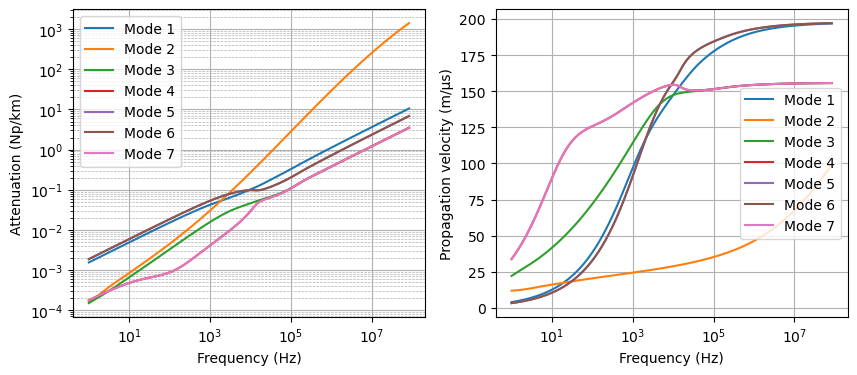

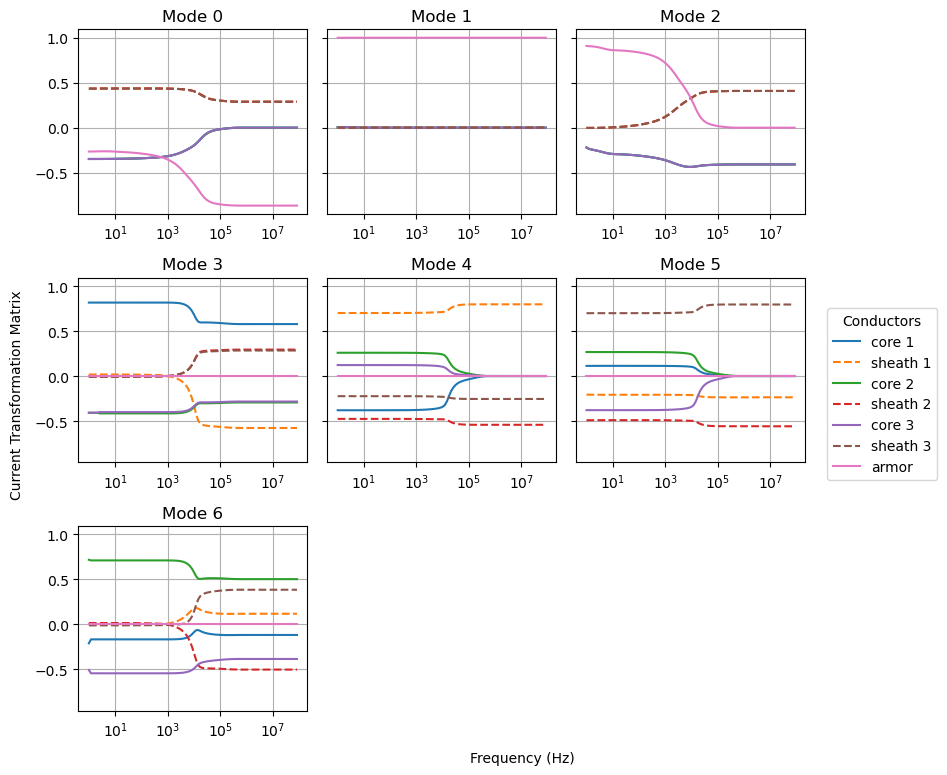

In [14]:
# normalization
omega = 2 * pi * fhz
w2u0e0 = -omega**2 * mu_0 * epsilon_0
S_omega = np.array([A[i] / (-w2u0e0[i]) - np.identity(N) for i in range(K)])

eigvals, eigvecs = eig_levenberg_marquardt(S_omega)

# Scale back the eigenvalues. Eigenvectors remain unchanged.
eigvals = np.array([-w2u0e0 * (1 + eigvals[:, i]) for i in range(N)]).T

fig1, fig2 = comp_plot_propagation(eigvals, eigvecs)
if save_results:
    fig1.savefig("../results/LM_vals.png")
    fig2.savefig("../results/LM_vecs.png")

Now it is pretty and continuous. The skin effect is now pretty clear from the current transformation matrix: at higher frequencies, the modal currents in the core conductors get smaller, while they get bigger in the sheaths.